In [1]:
%load_ext autoreload
%autoreload 2

import os

import torch
import numpy as np

from datatools.trace_animator import TraceAnimator
from dataset import SportsDataset
from models.utils import *

In [2]:
import torch

time_gap_prev = torch.load("./debug_files/time_gap_prev")
time_gap_curr = torch.load("./debug_files/time_gap_curr")

In [3]:
time_gap_curr_x = time_gap_curr[..., 0::6, None]
time_gap_curr_y = time_gap_curr[..., 1::6, None]

time_gap_curr = torch.cat([time_gap_curr_x, time_gap_curr_y], dim=-1).flatten(2,3)
time_gap_curr.shape

torch.Size([1, 200, 44])

In [4]:
(time_gap_prev == time_gap_curr).sum()

tensor(8800)

In [5]:
time_gap_curr.reshape(-1).shape[0]

8800

In [6]:
import torch

input_prev = torch.load("./debug_files/input_prev")
input_curr = torch.load("./debug_files/input_curr")

In [7]:
input_prev.shape

torch.Size([1, 200, 44])

In [8]:
input_curr = input_curr.reshape(1, 200, 22, -1)[..., : 2].flatten(2, 3) # [time, bs, players * feats]
input_curr.shape

torch.Size([1, 200, 44])

In [9]:
(input_prev == input_curr).sum()

tensor(8800, device='cuda:0')

In [10]:
import torch

target_prev = torch.load("./debug_files/target_prev")
target_curr = torch.load("./debug_files/target_curr")

In [11]:
target_curr = target_curr.reshape(1, 200, 22, -1)[..., : 2].flatten(2, 3) # [time, bs, players * feats]
target_curr.shape

torch.Size([1, 200, 44])

In [12]:
(target_prev == target_curr).sum()

tensor(8800, device='cuda:0')

In [13]:
import torch

mask_prev = torch.load("./debug_files/mask_prev").detach().cpu()
mask_curr = torch.load("./debug_files/mask_curr").detach().cpu()

In [14]:
mask_curr = mask_curr.reshape(1, 200, 22, -1)[..., : 2].flatten(2, 3) # [time, bs, players * feats]
mask_curr.shape

torch.Size([1, 200, 44])

In [15]:
(mask_prev == mask_curr).sum()

tensor(8800)

In [16]:
import torch

pred_prev = np.array(torch.load("./debug_files/pred_prev").detach().cpu().squeeze(0))
pred_curr = np.array(torch.load("./debug_files/pred_curr").detach().cpu().squeeze(0))

In [17]:
k = 0

obs_idxs = np.where((mask_curr[0, :, 2 * k] != 0) | (mask_curr[0, :, 2 * k + 1] != 0))
missing_idxs = np.setdiff1d(np.arange(200), obs_idxs)

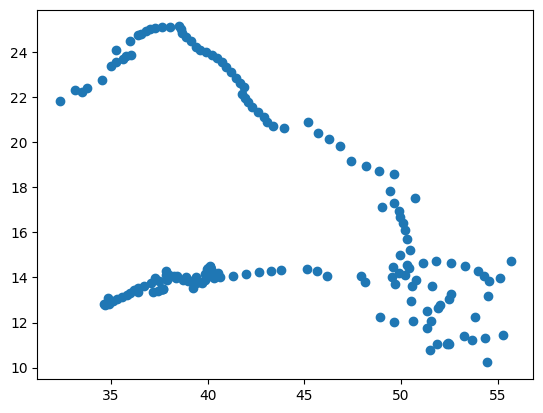

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(pred_curr[missing_idxs, 0] * 108, pred_curr[missing_idxs, 1] * 72)
plt.show()

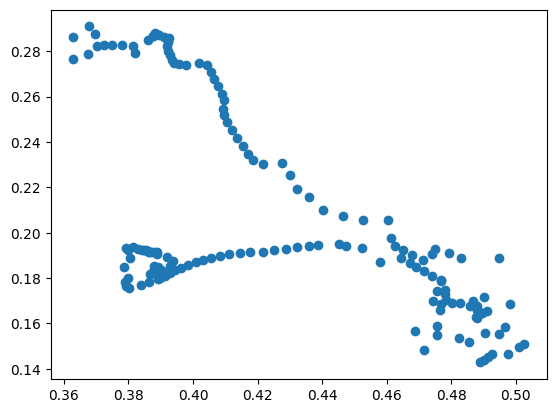

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(pred_prev[missing_idxs, 0], pred_prev[missing_idxs, 1])
plt.show()

## Getting input data

In [ ]:
dataset = "soccer" # ["soccer", "basketball", "afootball"]
window_size = 50 if dataset == "afootball" else 200
window_stride = 5

normalize = True
flip_pitch = False if dataset == "basketball" else True

In [ ]:
if dataset == "soccer":  # Soccer (Metrica) datasets
    metrica_files = ["match1.csv", "match2.csv", "match3_valid.csv"]
    metrica_paths = [f"data/metrica_traces/{f}" for f in metrica_files]
    train_paths = metrica_paths[:-1]
    valid_paths = metrica_paths[-1:]
    window_size = window_size
    episode_min_len = window_size

elif dataset == "basketball":  # Basketball (NBA) dataset
    nba_files = os.listdir("data/nba_traces")
    nba_paths = [f"data/nba_traces/{f}" for f in nba_files]
    nba_paths.sort()
    train_paths = nba_paths[0:1]
    valid_paths = nba_paths[98:99]
    # valid_paths = nba_paths[70:90]
    window_size = window_size
    episode_min_len = window_size

else:  # American football (NFL) dataset
    nfl_paths = ["data/nfl_traces/nfl_train.csv", "data/nfl_traces/nfl_test.csv"]
    train_paths = nfl_paths[:-1]
    valid_paths = nfl_paths[-1:]
    window_size = window_size
    episode_min_len = window_size

train_dataset = SportsDataset(
    sports=dataset,
    data_paths=train_paths,
    window_size=window_size,
    min_episode_size=episode_min_len,
    stride=window_stride,
    normalize=normalize,
    flip_pitch=flip_pitch,
)
valid_dataset = SportsDataset(
    sports=dataset,
    data_paths=valid_paths,
    window_size=window_size,
    min_episode_size=episode_min_len,
    stride=window_size,
    normalize=normalize,
    flip_pitch=False,
)

In [ ]:
player_data, ball_data = train_dataset[0]

player_data.unsqueeze_(0)
ball_data.unsqueeze_(0)

player_data.shape, ball_data.shape

In [ ]:
mask, missing_rate = generate_mask(
    data={"target": player_data, "ball": ball_data},
    sports=dataset,
    mode="camera",
    missing_rate=0.5,
)  # [bs, time, players]

mask = torch.tensor(mask, dtype=torch.float32)  # [bs, time, team_size]
mask = torch.repeat_interleave(mask, 6, dim=-1)

print(f"Mask shape : {mask.shape}")
print(f"Missing rate : {missing_rate}")

## Plotting Trajectories

In [ ]:
masked_input = player_data * mask
target = player_data
mask = mask

In [ ]:
bs, seq_len = masked_input.shape[:2]
n_players, _ = get_dataset_config(dataset=dataset)
n_features = 2

input = masked_input.reshape(bs, seq_len, n_players, -1)[..., : n_features].flatten(2, 3) # [time, bs, players * feats]
target = target.reshape(bs, seq_len, n_players, -1)[..., : n_features].flatten(2, 3) # [time, bs, players * feats]
mask = mask.reshape(bs, seq_len, n_players, -1)[..., : n_features].flatten(2, 3)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

k = 1

obs_idxs = np.where((mask[0, :, 2 * k] != 0) | (mask[0, :, 2 * k + 1] != 0))
missing_idxs = np.setdiff1d(np.arange(input[0].shape[0]), obs_idxs)

# Plot observed trajectories
plt.scatter(
    input[0, obs_idxs, 2 * k],
    input[0, obs_idxs, 2 * k + 1],
    marker="o",
    c="red",
    s=10,
    zorder=0,
    label="Observed"
)
# Plot target trajectories
plt.plot(target[0, :, 2 * k], target[0, :, 2 * k + 1], c="blue", alpha=0.6, label="Target")

plt.legend()
plt.show()

## Plotting Masking matrix

In [ ]:
mask_dict = {}
for missing_pattern in ["uniform", "playerwise", "camera"]:
    mask, missing_rate = generate_mask(
        data={"target": player_data, "ball": ball_data},
        sports=dataset,
        mode=missing_pattern,
        missing_rate=0.5,
    )  # [bs, time, players]

    mask = torch.tensor(mask, dtype=torch.float32)  # [bs, time, team_size]
    # mask = torch.repeat_interleave(mask, 6, dim=-1)

    mask_dict[missing_pattern] = mask

    print(f"Pattern : {missing_pattern}, Missing Rate : {missing_rate}")

In [ ]:
import matplotlib.colors as mcl
import matplotlib.patches as mpatches


colors_gray_to_blue = ["#F2F2F2", "#7895CB"]
cmap = mcl.LinearSegmentedColormap.from_list("custom_cmap", colors_gray_to_blue, gamma=2)

im = plt.imshow(mask_dict["uniform"][0], cmap = cmap)
labels = ["Missing", "Observed"]
values = [0, 1]
colors = [im.cmap(im.norm(value)) for value in values]
patches = [mpatches.Patch(color=colors[i], label= labels[i]) for i in range(len(values)) ]

cmap

In [ ]:
plt.rcParams["font.family"] = "sans-serif"
f, axes = plt.subplots(1,3)
f.set_size_inches((20,7))

for i, (k,v) in enumerate(mask_dict.items()):
    axes[i].imshow(mask_dict[k][0], cmap=cmap, interpolation="nearest", aspect="auto")
    axes[i].set_xticks([p for p in range(22) if p % 4 == 0])
    axes[i].set_xticklabels([p for p in range(22) if p % 4 == 0], fontsize=30)
    axes[i].set_yticks([s for s in range(200) if s % 40 == 0])
    axes[i].set_yticklabels([s for s in range(200) if s % 40 == 0], fontsize=30)

    axes[i].set_xlabel("Agent", fontsize=40)
    axes[i].set_ylabel("Time step", fontsize=40)
    if k == "playerwise":
        k = "agent-wise"
    axes[i].set_title(k.capitalize(), fontsize=45, pad=20)

f.legend(handles = patches, bbox_to_anchor = (0.5, -0.15), loc = "lower center", prop = {"size" : 30}, ncol = 2)

plt.tight_layout()
plt.show()

## Visualizing camera missing pattern

In [ ]:
import matplotlib.patches as patches
from shapely.geometry import Point, Polygon

In [ ]:
player_pos = reshape_tensor(player_data, upscale=True, dataset_type="soccer")  # [bs, time, players, 2]
ball_pos = normalize_tensor(ball_data, mode="upscale", dataset_type="soccer")

In [ ]:
time = 15
player_pos_ = player_pos[0, time] # [agents, 2]
ball_pos_ = ball_pos[0, time] # [2]

print(player_pos_.shape, ball_pos_.shape)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Camera settings
pitch_height = 72
pitch_width = 108
camera_info = (0, -20, 20, 30) # x, y, z, fov

pitch = Polygon([(0, 0), (0., pitch_height), (pitch_width, pitch_height), (pitch_width, 0)])

# Plot pitch and camera
x, y = pitch.exterior.xy
camera_loc = np.array([pitch_width/2, -20])

plt.plot(x, y, c="white", zorder=1)
plt.fill_between(x ,y, color="green", alpha=0.4, zorder=0, label="Pitch")
plt.scatter(*camera_loc, label="Camera")

# Plot camera view
camera_vertices = compute_camera_coverage(ball_pos_)
shp = patches.Polygon(list(camera_vertices), color="b", alpha=0.6)
plt.gca().add_patch(shp)

ball_camera_dist = math.sqrt((ball_pos_[0] - camera_loc[0])**2 + (ball_pos_[1] - camera_loc[1])**2)
camera_fov = math.radians(camera_info[3]) # in degree
camera_ball_angle = math.pi/2 - math.atan(abs(camera_loc[1] - ball_pos_[1]) / abs(camera_loc[0] - ball_pos_[0]))

ball_fov_dist_x = (ball_camera_dist * math.tan(camera_fov / 2)) * math.cos(camera_ball_angle)
ball_fov_dist_y = (ball_camera_dist * math.tan(camera_fov / 2)) * math.sin(camera_ball_angle)

plt.axline((ball_pos_[0] - ball_fov_dist_x, ball_pos_[1] - ball_fov_dist_y), camera_loc, linewidth=2, zorder=2, alpha=0.6)
plt.axline((ball_pos_[0] + ball_fov_dist_x, ball_pos_[1] + ball_fov_dist_y), camera_loc, linewidth=2, zorder=2, alpha=0.6)

# Plot players and ball
c = 0
polygon = Polygon(camera_vertices)
for i, p in enumerate(range(player_pos_.shape[0])):
    p_x, p_y = player_pos_[p, 0].item(), player_pos_[p, 1].item()
    
    p_color = "red" if i < 11 else "blue"
    if i == 0:
        plt.scatter(p_x, p_y, color=p_color, label="Red Team")
    elif i == 11:
        plt.scatter(p_x, p_y, color=p_color, label="Blue Team")
    else:
        plt.scatter(p_x, p_y, color=p_color)

    point = Point(p_x, p_y)
    is_contain = polygon.contains(point)
    if is_contain:
        c += 1

plt.scatter(*ball_pos_, color="white", label="Ball", s=13)

plt.axis('equal')
plt.legend()
plt.show()

print(f"Number of players in the camera view : {c} / {player_pos_.shape[0]}")
print(f"Missing ratio : {100 - (c / player_pos_.shape[0] * 100)}")